In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
#import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import gc
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
from sklearn import metrics
import scipy.stats as stats

from sklearn.model_selection import permutation_test_score
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

plt.style.use('seaborn')
sns.set(font_scale=2)
pd.set_option('display.max_columns', 500)

In [2]:
def analysis(col, tops = 10):
    temp = train[col].value_counts()
    temp = temp.iloc[:tops].index
    #temp = train.index
    temp_df = train[train[col].isin(temp)]
#     prob = temp_df[col].value_counts(normalize=True)
#     draw = np.random.choice(prob.index, p=prob, size=len(temp_df))
#     output = pd.Series(draw).value_counts(normalize=True).rename('simulated')
#     zeros = set(temp_df[col].dropna().unique()).difference(set(output.index))
#     output = output.append(pd.Series([0 for i in zeros], index = zeros)) / (temp_df[col].value_counts())
    temp_df['shuffle'] = temp_df['HasDetections'].sample(replace=False, n=len(temp_df)).reset_index(drop=True)
    output = temp_df[temp_df['shuffle'] == 1][col].value_counts() / temp_df[col].value_counts()
    pd.DataFrame({'train_data': temp_df[temp_df['HasDetections'] == 1][col].value_counts()/ temp_df[col].value_counts(),
                         'random_data': output}).plot(kind = 'bar', figsize=(20,10))
    plt.title('Percent of Has detections by {} (most of the catogaries)'.format(col))
    
    display(pd.DataFrame({'train_data': temp_df[temp_df['HasDetections'] == 1][col].value_counts()/ temp_df[col].value_counts(),
                         'random_data': output}))
    return stats.ks_2samp(temp_df[temp_df['HasDetections'] == 1][col].value_counts(normalize = True),
                output)




#stats.chi2_contingency([temp_df.groupby(col).HasDetections.mean(),
#                temp_df.groupby(col).random_data.mean()])


In [3]:
COLS = [
    'HasDetections',
    'GeoNameIdentifier',
    'CountryIdentifier'
]

In [4]:
train = pd.read_csv("train.csv", sep=',', engine='c', usecols=COLS)

In [5]:
#top 40 contries analysis

,train_data,random_data
10.0,0.511848,0.425225
15.0,0.439316,0.427997
24.0,0.441928,0.424914
35.0,0.507216,0.426260
45.0,0.469069,0.425998
52.0,0.510999,0.425478
53.0,0.517883,0.426859
57.0,0.540070,0.427874
68.0,0.454544,0.425157
76.0,0.548960,0.426389


Ks_2sampResult(statistic=1.0, pvalue=6.133847783205273e-19)

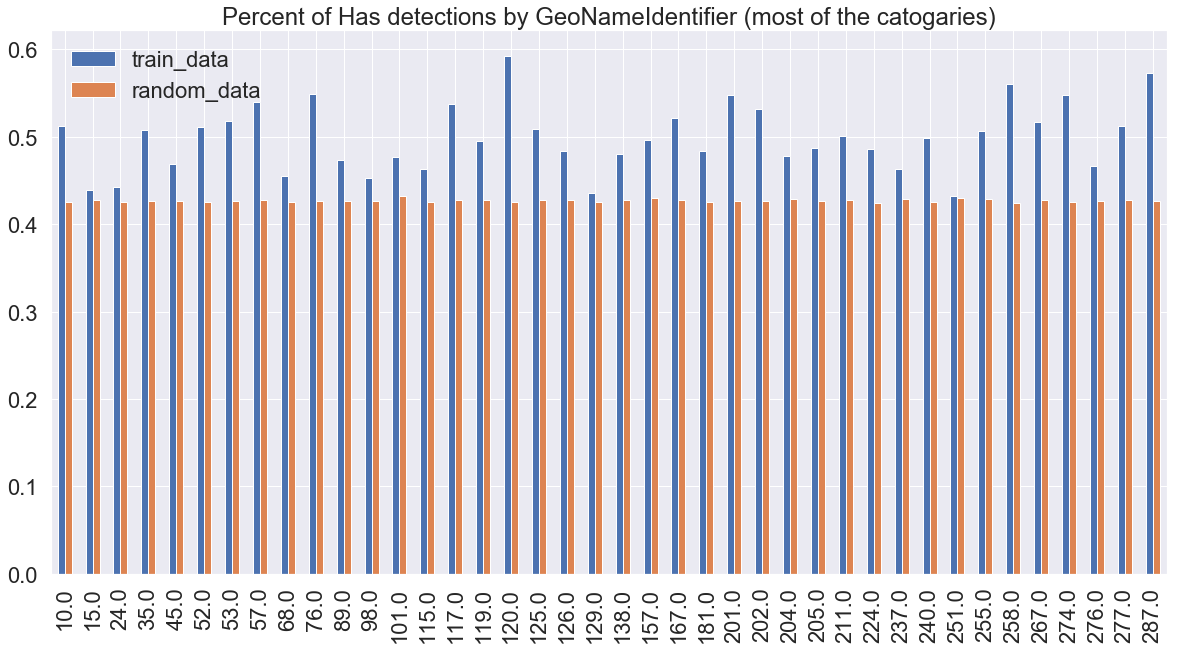

In [6]:
analysis(COLS[1], 40)

In [7]:
#from the histogram, we see there is a difference in top 4 counties

,train_data,random_data
9,0.506709,0.362701
12,0.459381,0.363193
19,0.452238,0.365839
29,0.505318,0.363857
35,0.476030,0.363344
41,0.507615,0.366280
43,0.512030,0.365131
44,0.533652,0.365011
50,0.458017,0.366223
51,0.478736,0.364130


Ks_2sampResult(statistic=1.0, pvalue=6.133847783205273e-19)

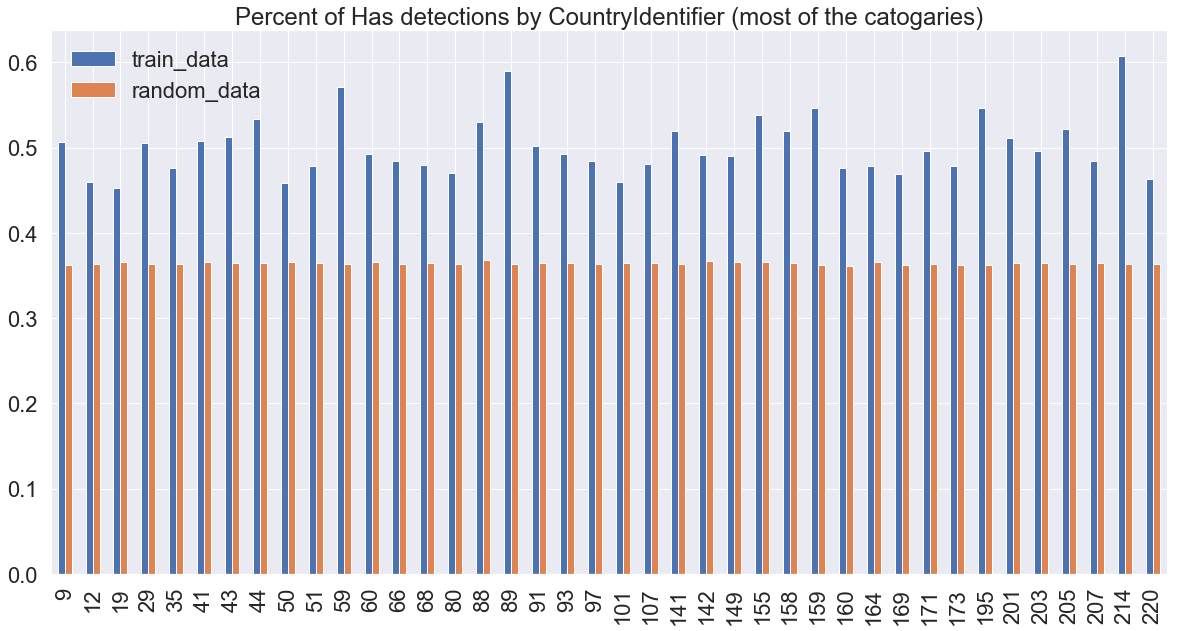

In [8]:
analysis(COLS[2], 40)

In [9]:
# We assume there is no significant influence when malware detection

In [10]:
# random forest clustering to confirm

In [11]:
def skl(col):
    nominal_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    preproc = ColumnTransformer(transformers=[('onehot', nominal_transformer, col)],\
                                          remainder='drop')
    clf = RandomForestClassifier(n_estimators=7, max_depth=60)
    pl = Pipeline(steps=[('preprocessor', preproc),
                    ('clf', clf)
                    ])
    return pl

In [12]:
X_train, X_test, y_train, y_test = train_test_split(train.dropna().drop('HasDetections',axis = 1)\
                                                    , train.dropna()['HasDetections'], test_size=0.25)
N = len(y_test)
y_random = y_test.sample(replace=False, frac = 1)

In [13]:
output = pd.DataFrame(columns = ['Observation accuracy', 'Random_Data accuracy'], index = COLS[1:])
for i in COLS[1:]:
    pl = skl([i])
    pl.fit(X_train, y_train)
    pred_score = pl.score(X_test, y_test)
    rand_score = pl.score(X_test, y_random)
    output.loc[i, 'Observation accuracy'] = pred_score
    output.loc[i, 'Random_Data accuracy'] = rand_score
pl = skl(COLS[1:])
pl.fit(X_train, y_train)
pred_score = pl.score(X_test, y_test)
rand_score = pl.score(X_test, y_random)
output.loc['combined', 'Observation accuracy'] = pred_score
output.loc['combined', 'Random_Data accuracy'] = rand_score

In [14]:
output

,Observation accuracy,Random_Data accuracy
GeoNameIdentifier,0.525165,0.500321
CountryIdentifier,0.528054,0.500553
combined,0.532115,0.500415


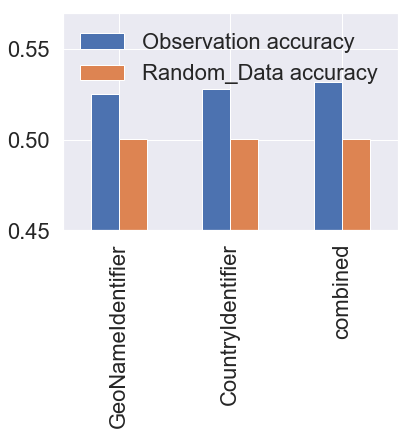

In [15]:
output.plot(kind = 'bar', ylim = (0.45, 0.57))